In [1]:
# Setup access to my Google Drive
from google.colab import drive
drive.mount('/content/drive',  force_remount=False)

# Set the working directory
import os
os.chdir('/content/drive/MyDrive/ViT_myWorks/')
import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [2]:
!pip install -q torchmetrics
!pip install --upgrade pytorch-pretrained-vit
!pip install efficientnet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-pretrained-vit: filename=pytorch_pretrained_vit-0.0.7-py3-none-any.whl size=11116 sha256=45ddb24103bf7c1c95f55e02580e8ccaace3d9dc724f9dc8a810c7728726ed14
  Stored in directory: /root/.cache/pip/wheels/2d/46/ad/12007be9d377d0fbf27ef75b6e47ed92832ab6b70dbf004b6f
Successfully built pytorch-pretrained-vit
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=7d9110dec93c68c84e8eee60fa5e6e332e0afc559bb615cbf530aba0fdecde5e
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [1]:
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import numpy as np
import random
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
import PIL.Image as Image
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
import math
import scipy.io as sio
from efficientnet_pytorch import EfficientNet

In [2]:
from resViT.model import *
from resViT.train import *
from resViT.loaddata import *

In [3]:
tarData = 'BloodCell';

root = './Dataset/'
img_size=128

classNames = [f for f in os.listdir(root + 'train/') if not f.endswith('.ini')]
numClass = len(classNames)
label_map = {i : className for i, className in enumerate(classNames)}

tr_df = pd.DataFrame(columns = ['img', 'label'])
j=0
for i in label_map:
  img_path = os.path.join(root, 'train/', label_map[i])
  for img in os.listdir(img_path):
      if not img.endswith('.ini'):
          image = os.path.join(img_path, img)
          tr_df  = pd.concat((tr_df, pd.DataFrame({'img':[image], 'label': i})), ignore_index = True)
          j+=1


te_df = pd.DataFrame(columns = ['img', 'label'])
j=0
for i in label_map:
  img_path = os.path.join(root, 'test/', label_map[i])
  for img in os.listdir(img_path):
      if not img.endswith('.ini'):
          image = os.path.join(img_path, img)
          te_df  = pd.concat((te_df, pd.DataFrame({'img':[image], 'label': i})), ignore_index = True)
          j+=1


tr_df.head()

,img,label
0,./Dataset/train/NEUTROPHIL\_157_5718.jpeg,0
1,./Dataset/train/NEUTROPHIL\_115_1623.jpeg,0
2,./Dataset/train/NEUTROPHIL\_103_4535.jpeg,0
3,./Dataset/train/NEUTROPHIL\_33_616.jpeg,0
4,./Dataset/train/NEUTROPHIL\_63_7112.jpeg,0


In [8]:
len(tr_df)

9956

In [4]:
from sklearn.model_selection import train_test_split
tr_df, Test = train_test_split(tr_df, test_size = 0.6, random_state = 42)

In [5]:
TrainLoader = DataLoader(loadData(tr_df), batch_size=batch_size, shuffle=True)
TestLoader = DataLoader(loadData(te_df), batch_size=batch_size, shuffle=False)

# EDA

In [ ]:
tar = 0
# root = '/content/cwruData/' + tarData[tar] + '/' #Running from colab
root = './cwruData/' + tarData[tar] + '/' #Running from local
classNames = ['n', 'ir', 'b', 'or']
numClass = len(classNames)
label_map = {i : className for i, className in enumerate(classNames)}
print(f'\nLabels are mapped as\n {label_map}')


Labels are mapped as
 {0: 'n', 1: 'ir', 2: 'b', 3: 'or'}


In [ ]:
Train = pd.DataFrame(columns = ['img', 'label'])
j=0
for i in label_map:
  img_path = os.path.join(root, 'train', label_map[i])
  for img in os.listdir(img_path):
    image = os.path.join(img_path, img)
    Train  = pd.concat((Train, pd.DataFrame({'img':[image], 'label': i})), ignore_index = True)
    j+=1
Train.head()

,img,label
0,./cwruData/FE_tar_7_1/train\n\n184.png,0
1,./cwruData/FE_tar_7_1/train\n\n217.png,0
2,./cwruData/FE_tar_7_1/train\n\n219.png,0
3,./cwruData/FE_tar_7_1/train\n\n216.png,0
4,./cwruData/FE_tar_7_1/train\n\n218.png,0


In [ ]:
len(Train)

1024

In [ ]:
Test = pd.DataFrame(columns = ['img', 'label'])
j=0
for i in label_map:
  img_path = os.path.join(root, 'test', label_map[i])
  for img in os.listdir(img_path):
    image = os.path.join(img_path, img)
    Test  = pd.concat((Test, pd.DataFrame({'img':[image], 'label': i})), ignore_index = True)
    j+=1
Test.head()

,img,label
0,./cwruData/FE_tar_7_1/test\n\n51.png,0
1,./cwruData/FE_tar_7_1/test\n\n76.png,0
2,./cwruData/FE_tar_7_1/test\n\n75.png,0
3,./cwruData/FE_tar_7_1/test\n\n35.png,0
4,./cwruData/FE_tar_7_1/test\n\n62.png,0


In [ ]:
len(Test)

320

In [ ]:
Val = pd.DataFrame(columns = ['img', 'label'])
j=0
for i in label_map:
  img_path = os.path.join(root, 'val', label_map[i])
  for img in os.listdir(img_path):
    image = os.path.join(img_path, img)
    Val  = pd.concat((Val, pd.DataFrame({'img':[image], 'label': i})), ignore_index = True)
    j+=1
Val.head()

,img,label
0,./cwruData/FE_tar_7_1/val\n\n26.png,0
1,./cwruData/FE_tar_7_1/val\n\n29.png,0
2,./cwruData/FE_tar_7_1/val\n\n28.png,0
3,./cwruData/FE_tar_7_1/val\n\n30.png,0
4,./cwruData/FE_tar_7_1/val\n\n27.png,0


In [ ]:
len(Val)

256

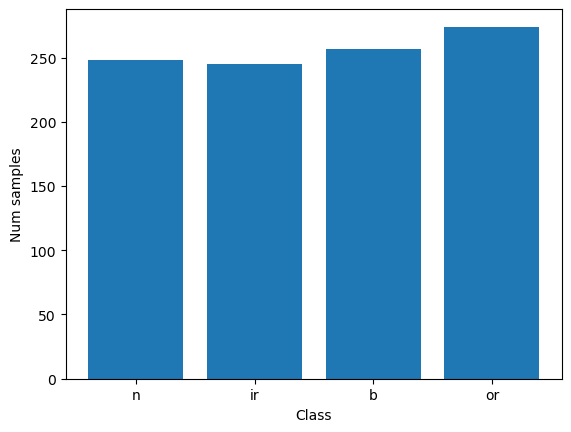

In [ ]:
def vis_data_class_distribution(labels, class_names):
    #   labels: list of integers representing the class of each samples
    #   class_names: a list of class names corresponding to each class
    counts = [sum(labels == c) for c in range(len(class_names))]
    # plt.title(f'Data class distribution')
    plt.bar(class_names, counts)
    plt.xlabel('Class')
    plt.ylabel('Num samples')
    plt.show()

vis_data_class_distribution(Train['label'],  classNames)

# Proposed ViT training with Knowledge transfer method

In [7]:
# Main Training loop for all target dataset with pretrained sourse model on CWRU DE fault, Dia=7Mil, load = 0hp

Model = torch.load('./saved_models/ViT_src_7_0.pth', map_location=device)
optC = torch.optim.Adam(Model.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss() #Define classification loss
print(f'Fine tuning model for traget data: {tarData}')
Model = train_pr(Model, TrainLoader, TestLoader, optC, criterion)
torch.save(Model,'./saved_models/ViT_'+tarData+'.pth')

Fine tuning model for traget data: BloodCell
Starting Training Loop...
[0/20]   Train Accuracy = 72.40    Val Accuracy = 66.73
[1/20]   Train Accuracy = 87.82    Val Accuracy = 69.81
[2/20]   Train Accuracy = 93.01    Val Accuracy = 77.93
[3/20]   Train Accuracy = 92.27    Val Accuracy = 87.38
[4/20]   Train Accuracy = 96.29    Val Accuracy = 95.16
[5/20]   Train Accuracy = 97.21    Val Accuracy = 97.37
[6/20]   Train Accuracy = 96.10    Val Accuracy = 95.23
[7/20]   Train Accuracy = 97.62    Val Accuracy = 97.55
[8/20]   Train Accuracy = 98.35    Val Accuracy = 95.70
[9/20]   Train Accuracy = 98.41    Val Accuracy = 97.47
[10/20]   Train Accuracy = 98.88    Val Accuracy = 96.68
[11/20]   Train Accuracy = 98.24    Val Accuracy = 96.55
[12/20]   Train Accuracy = 98.17    Val Accuracy = 96.59
[13/20]   Train Accuracy = 97.78    Val Accuracy = 96.40
[14/20]   Train Accuracy = 98.34    Val Accuracy = 95.93
[15/20]   Train Accuracy = 99.22    Val Accuracy = 98.47
[16/20]   Train Accuracy = 

Validation Accuracy =  100.0
__________________________________________________
Pricision Score = 1.0
__________________________________________________
F_1 Score =  1.0
__________________________________________________
Recall Score =  1.0
__________________________________________________
Response time per batch 0.5007915496826172


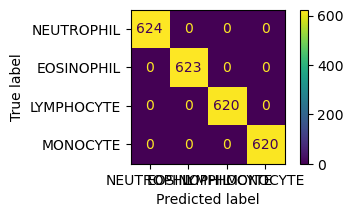

In [8]:
# Validate and Visualize
Model = torch.load('./saved_models/ViT_'+tarData+'.pth', map_location=device)
val_acc, cm, prec, f1, recall, time_batch = validate_pr(Model, TestLoader, numClass)
print('Validation Accuracy = ', 100*val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm, classNames)

perfvit = {'Modelname':['ViT_attn'+tarData], 'Val Acc.': 100*val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}

In [ ]:
perfvit = pd.DataFrame(perfvit)
# perfData.to_csv('results_'+ tarData[tar]+ '.csv')
perfvit

# Train benchmark models for comparisions
## Models: Standard ViT, EfficientNet, ResNeXt, DenseNet, VGGNet, GoogleNet, SqeezeNet

### Standard ViT wth 12 encoder block pre-trained in ImageNet1k

In [14]:
Model = ViTpretrain(img_size, numClass)
Model.to(device)
optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
print(f'Fine tuning pre-trained ViT model for traget data: {tarData}')
Model = train(Model, TrainLoader, TestLoader, optC, criterion)
torch.save(Model,'./saved_models/ViT_pre_'+ tarData +'.pth')

Downloading: "https://github.com/lukemelas/PyTorch-Pretrained-ViT/releases/download/0.0.2/B_16_imagenet1k.pth" to /root/.cache/torch/hub/checkpoints/B_16_imagenet1k.pth
100%|██████████| 331M/331M [00:03<00:00, 109MB/s]


Resized positional embeddings from torch.Size([1, 577, 768]) to torch.Size([1, 65, 768])
Loaded pretrained weights.
Fine tuning pre-trained ViT model for traget data: BloodCell
Starting Training Loop...
[0/20]   Train Accuracy = 82.37    Val Accuracy = 83.96
[1/20]   Train Accuracy = 94.88    Val Accuracy = 82.47
[2/20]   Train Accuracy = 98.12    Val Accuracy = 79.98
[3/20]   Train Accuracy = 98.47    Val Accuracy = 87.05
[4/20]   Train Accuracy = 99.60    Val Accuracy = 85.61
[5/20]   Train Accuracy = 99.50    Val Accuracy = 84.24
[6/20]   Train Accuracy = 99.52    Val Accuracy = 80.86
[7/20]   Train Accuracy = 99.65    Val Accuracy = 86.21
[8/20]   Train Accuracy = 99.75    Val Accuracy = 87.09
[9/20]   Train Accuracy = 99.92    Val Accuracy = 86.81
[10/20]   Train Accuracy = 99.50    Val Accuracy = 83.07
[11/20]   Train Accuracy = 99.65    Val Accuracy = 85.89
[12/20]   Train Accuracy = 99.90    Val Accuracy = 85.32
[13/20]   Train Accuracy = 99.95    Val Accuracy = 85.36
[14/20]  

Validation Accuracy =  86.28870124648171
__________________________________________________
Pricision Score = 0.8783623769314275
__________________________________________________
F_1 Score =  0.8640558781358731
__________________________________________________
Recall Score =  0.862921518420567
__________________________________________________
Response time per batch
 0.07371950149536133


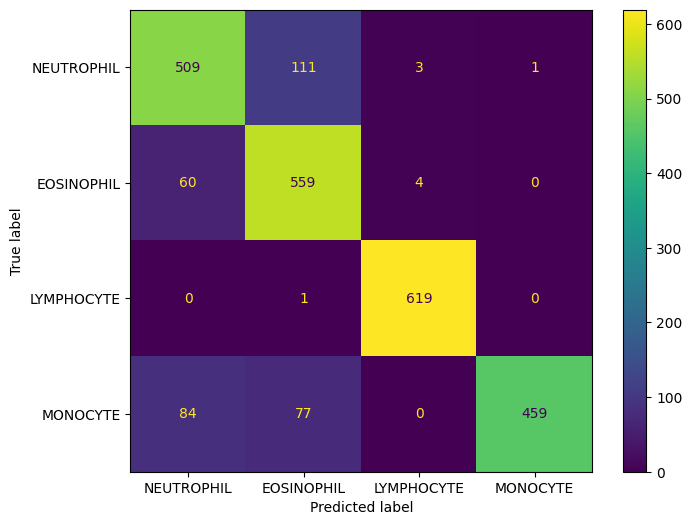

In [8]:
# Validate and Visualize
perfvit_pre = pd.DataFrame({'Metrics':['Val Acc.', 'Precision', 'F1_score', 'Recall']})
Model = torch.load('./saved_models/ViT_pre_'+ tarData +'.pth', map_location=device)
val_acc, cm, prec, f1, recall, time_batch = validate(Model, TestLoader, numClass)
print('Validation Accuracy = ', val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch\n', time_batch)
disp_conf_matrix(cm, classNames)

perfvit_pre = {'Modelname':['ViT_pre_' + tarData], 'Val Acc.': val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}
# pd.concat((perfvit_pre, pd.DataFrame({tarData : [val_acc, prec, f1, recall]})), ignore_index = True, axis=1)

### EfficientNet

In [16]:
# Main Training loop for all target dataset with pretrained sourse model on CWRU DE fault, Dia=7Mil, load = 0hp
Model = EfficientNet.from_pretrained('efficientnet-b1')
Model._fc = EffNetFC(numClass)
Model.to(device)
optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
print(f'Fine tuning EfficentNet model for traget data: {tarData}')
Model = train(Model, TrainLoader, TestLoader, optC, criterion)
torch.save(Model,'./saved_models/efficient_'+tarData+'.pth')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 196MB/s]


Loaded pretrained weights for efficientnet-b1
Fine tuning EfficentNet model for traget data: BloodCell
Starting Training Loop...
[0/20]   Train Accuracy = 51.66    Val Accuracy = 72.09
[1/20]   Train Accuracy = 94.73    Val Accuracy = 84.36
[2/20]   Train Accuracy = 99.67    Val Accuracy = 86.69
[3/20]   Train Accuracy = 100.00    Val Accuracy = 85.04
[4/20]   Train Accuracy = 100.00    Val Accuracy = 86.89
[5/20]   Train Accuracy = 100.00    Val Accuracy = 83.35
[6/20]   Train Accuracy = 100.00    Val Accuracy = 87.29
[7/20]   Train Accuracy = 100.00    Val Accuracy = 86.77
[8/20]   Train Accuracy = 100.00    Val Accuracy = 85.32
[9/20]   Train Accuracy = 100.00    Val Accuracy = 86.05
[10/20]   Train Accuracy = 99.97    Val Accuracy = 86.13
[11/20]   Train Accuracy = 100.00    Val Accuracy = 84.68
[12/20]   Train Accuracy = 100.00    Val Accuracy = 85.81
[13/20]   Train Accuracy = 100.00    Val Accuracy = 85.52
[14/20]   Train Accuracy = 100.00    Val Accuracy = 86.77
[15/20]   Train

Validation Accuracy =  87.81664656212304
__________________________________________________
Pricision Score = 0.8947116961942257
__________________________________________________
F_1 Score =  0.879932682783039
__________________________________________________
Recall Score =  0.8781556107749928
__________________________________________________
Response time per batch 0.07070040702819824


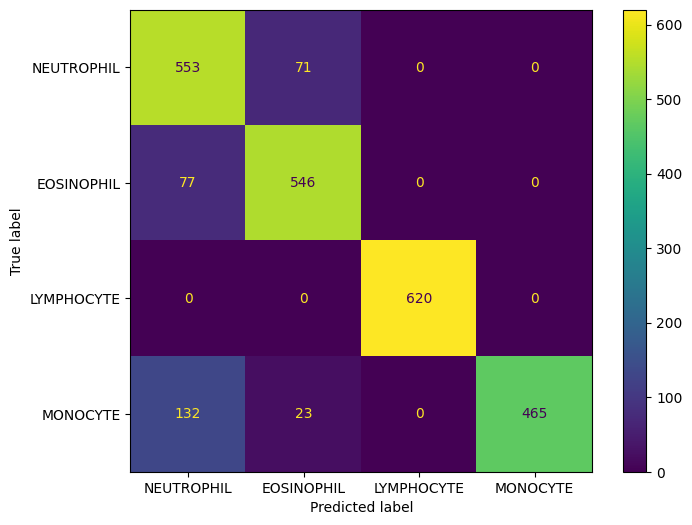

In [17]:
# Validate and Visualize
Model = torch.load('./saved_models/efficient_'+tarData+'.pth', map_location=device)
val_acc, cm, prec, f1, recall, time_batch = validate(Model, TestLoader, numClass)
print('Validation Accuracy = ', val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm, classNames)

perfEffNet = {'Modelname':['EfficientNet_'+tarData], 'Val Acc.': val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}

### ResNeXt

In [18]:
# Main Training loop for all target dataset with pretrained sourse model on CWRU DE fault, Dia=7Mil, load = 0hp

Model = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True)
Model.fc = ResNetFC(numClass)
Model.to(device)
optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
print(f'Fine tuning ResNeXt model for traget data: {tarData}')
Model = train(Model, TrainLoader, TestLoader, optC, criterion)
torch.save(Model,'./saved_models/ResNeXt_'+tarData+'.pth')

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:01<00:00, 92.4MB/s]


Fine tuning ResNeXt model for traget data: BloodCell
Starting Training Loop...
[0/20]   Train Accuracy = 92.97    Val Accuracy = 83.51
[1/20]   Train Accuracy = 99.82    Val Accuracy = 82.87
[2/20]   Train Accuracy = 100.00    Val Accuracy = 84.44
[3/20]   Train Accuracy = 99.97    Val Accuracy = 83.07
[4/20]   Train Accuracy = 100.00    Val Accuracy = 87.13
[5/20]   Train Accuracy = 99.95    Val Accuracy = 85.77
[6/20]   Train Accuracy = 99.85    Val Accuracy = 87.33
[7/20]   Train Accuracy = 100.00    Val Accuracy = 87.70
[8/20]   Train Accuracy = 99.97    Val Accuracy = 88.78
[9/20]   Train Accuracy = 99.72    Val Accuracy = 85.89
[10/20]   Train Accuracy = 99.92    Val Accuracy = 88.26
[11/20]   Train Accuracy = 99.97    Val Accuracy = 87.37
[12/20]   Train Accuracy = 99.92    Val Accuracy = 87.70
[13/20]   Train Accuracy = 100.00    Val Accuracy = 88.66
[14/20]   Train Accuracy = 99.95    Val Accuracy = 87.86
[15/20]   Train Accuracy = 100.00    Val Accuracy = 87.17
[16/20]   Trai

Validation Accuracy =  87.7362283876156
__________________________________________________
Pricision Score = 0.8992490893108392
__________________________________________________
F_1 Score =  0.8799716360818375
__________________________________________________
Recall Score =  0.8773401808865292
__________________________________________________
Response time per batch 0.010017633438110352


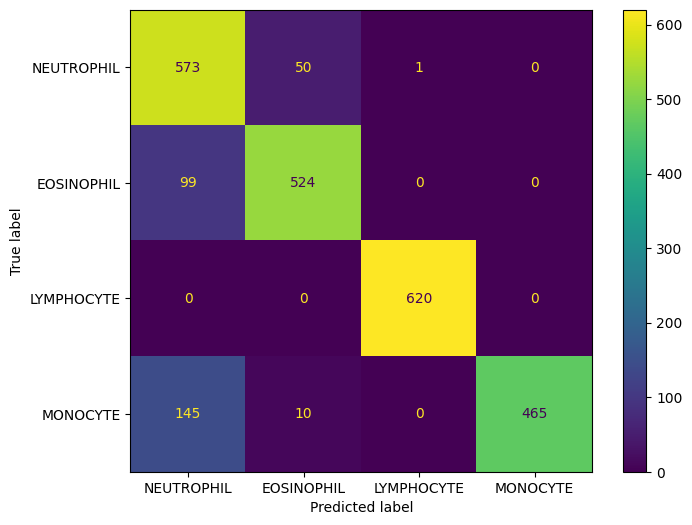

In [19]:
# Validate and Visualize
Model = torch.load('./saved_models/ResNeXt_'+tarData+'.pth', map_location=device)
val_acc, cm, prec, f1, recall, time_batch = validate(Model, TestLoader, numClass)
print('Validation Accuracy = ', val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm, classNames)

perfResNeXt = {'Modelname':['ResNeXt_'+tarData], 'Val Acc.': val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}

### DenseNet

In [9]:
# Main Training loop for all target dataset with pretrained sourse model on CWRU DE fault, Dia=7Mil, load = 0hp

Model = DenseNet(numClass)
Model.to(device)
optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
print(f'Fine tuning DenseNet model for traget data: {tarData}')
Model = train(Model, TrainLoader, TestLoader, optC, criterion)
torch.save(Model,'./saved_models/DenseNet_'+tarData+'.pth')

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:01<00:00, 28.4MB/s]


Fine tuning DenseNet model for traget data: BloodCell
Starting Training Loop...
[0/20]   Train Accuracy = 88.80    Val Accuracy = 80.98
[1/20]   Train Accuracy = 99.95    Val Accuracy = 84.16
[2/20]   Train Accuracy = 99.92    Val Accuracy = 79.90
[3/20]   Train Accuracy = 100.00    Val Accuracy = 84.08
[4/20]   Train Accuracy = 100.00    Val Accuracy = 86.17
[5/20]   Train Accuracy = 100.00    Val Accuracy = 85.32
[6/20]   Train Accuracy = 100.00    Val Accuracy = 86.37
[7/20]   Train Accuracy = 99.97    Val Accuracy = 83.72
[8/20]   Train Accuracy = 100.00    Val Accuracy = 82.95
[9/20]   Train Accuracy = 100.00    Val Accuracy = 84.52
[10/20]   Train Accuracy = 99.97    Val Accuracy = 76.92
[11/20]   Train Accuracy = 100.00    Val Accuracy = 86.05
[12/20]   Train Accuracy = 99.87    Val Accuracy = 85.77
[13/20]   Train Accuracy = 99.95    Val Accuracy = 85.69
[14/20]   Train Accuracy = 99.85    Val Accuracy = 85.56
[15/20]   Train Accuracy = 100.00    Val Accuracy = 80.90
[16/20]   

Validation Accuracy =  83.23281061519904
__________________________________________________
Pricision Score = 0.8604935679178807
__________________________________________________
F_1 Score =  0.8368171883652946
__________________________________________________
Recall Score =  0.8324026794758943
__________________________________________________
Response time per batch 0.0382533073425293


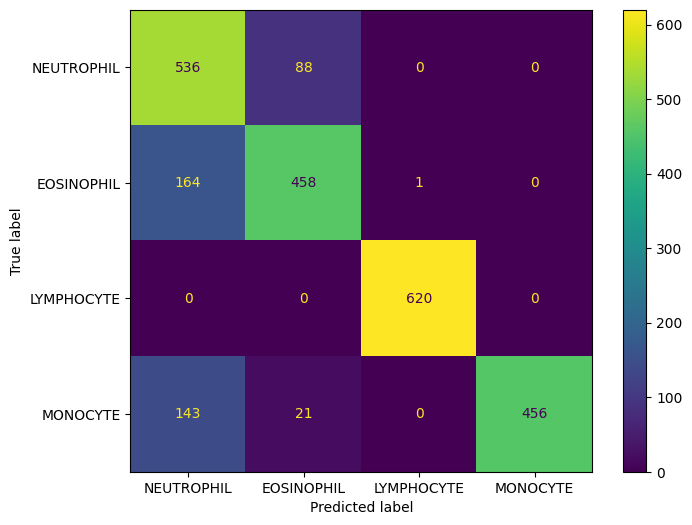

In [10]:
# Validate and Visualize
Model = torch.load('./saved_models/DenseNet_'+tarData+'.pth', map_location=device)
val_acc, cm, prec, f1, recall, time_batch = validate(Model, TestLoader, numClass)
print('Validation Accuracy = ', val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm, classNames)

perfDenseNet = {'Modelname':['DenseNet_'+tarData], 'Val Acc.': val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}

### vgg16Net

In [11]:
# Main Training loop for all target dataset with pretrained sourse model on CWRU DE fault, Dia=7Mil, load = 0hp

Model = vgg16Net(numClass)
Model.to(device)
optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
print(f'Fine tuning vgg16Net model for traget data: {tarData}')
Model = train(Model, TrainLoader, TestLoader, optC, criterion)
torch.save(Model,'./saved_models/vgg16Net_'+tarData+'.pth')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 79.4MB/s]


Fine tuning vgg16Net model for traget data: BloodCell
Starting Training Loop...
[0/20]   Train Accuracy = 70.97    Val Accuracy = 68.96
[1/20]   Train Accuracy = 95.45    Val Accuracy = 87.33
[2/20]   Train Accuracy = 96.86    Val Accuracy = 88.62
[3/20]   Train Accuracy = 99.47    Val Accuracy = 87.25
[4/20]   Train Accuracy = 99.87    Val Accuracy = 75.87
[5/20]   Train Accuracy = 99.60    Val Accuracy = 88.06
[6/20]   Train Accuracy = 99.72    Val Accuracy = 87.62
[7/20]   Train Accuracy = 99.82    Val Accuracy = 88.38
[8/20]   Train Accuracy = 100.00    Val Accuracy = 87.82
[9/20]   Train Accuracy = 100.00    Val Accuracy = 88.06
[10/20]   Train Accuracy = 100.00    Val Accuracy = 87.98
[11/20]   Train Accuracy = 100.00    Val Accuracy = 87.98
[12/20]   Train Accuracy = 100.00    Val Accuracy = 88.02
[13/20]   Train Accuracy = 100.00    Val Accuracy = 88.06
[14/20]   Train Accuracy = 100.00    Val Accuracy = 88.06
[15/20]   Train Accuracy = 100.00    Val Accuracy = 88.06
[16/20]   

Validation Accuracy =  87.97748291113791
__________________________________________________
Pricision Score = 0.8981365861874542
__________________________________________________
F_1 Score =  0.8817817509562713
__________________________________________________
Recall Score =  0.8797465993744084
__________________________________________________
Response time per batch 0.0018153190612792969


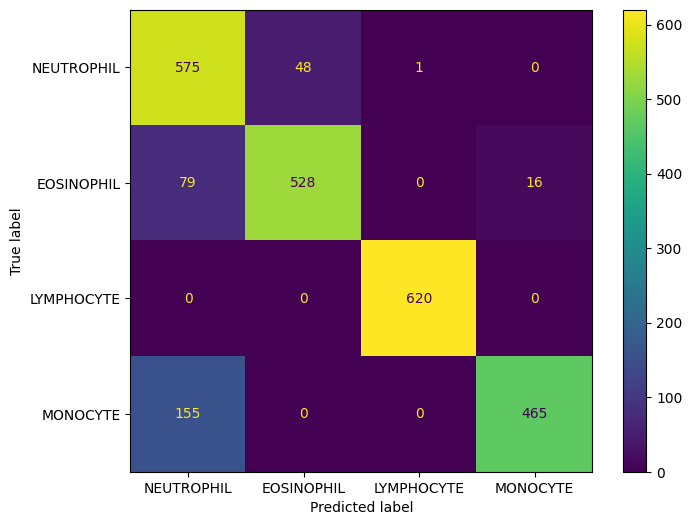

In [12]:
# Validate and Visualize
Model = torch.load('./saved_models/vgg16Net_'+tarData+'.pth', map_location=device)
val_acc, cm, prec, f1, recall, time_batch = validate(Model, TestLoader, numClass)
print('Validation Accuracy = ', val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm, classNames)

perfvgg16Net = {'Modelname':['vgg16Net_'+tarData], 'Val Acc.': val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}

### GoogleNet

In [13]:
# Main Training loop for all target dataset with pretrained sourse model on CWRU DE fault, Dia=7Mil, load = 0hp

Model = googleNet(numClass)
Model.to(device)
optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
print(f'Fine tuning GoogleNet model for traget data: {tarData}')
Model = train(Model, TrainLoader, TestLoader, optC, criterion)
torch.save(Model,'./saved_models/GoogleNet_'+tarData+'.pth')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 78.8MB/s]


Fine tuning GoogleNet model for traget data: BloodCell
Starting Training Loop...
[0/20]   Train Accuracy = 81.54    Val Accuracy = 86.17
[1/20]   Train Accuracy = 99.27    Val Accuracy = 84.48
[2/20]   Train Accuracy = 99.97    Val Accuracy = 84.24
[3/20]   Train Accuracy = 100.00    Val Accuracy = 84.96
[4/20]   Train Accuracy = 100.00    Val Accuracy = 85.65
[5/20]   Train Accuracy = 100.00    Val Accuracy = 84.24
[6/20]   Train Accuracy = 99.97    Val Accuracy = 86.33
[7/20]   Train Accuracy = 99.92    Val Accuracy = 87.13
[8/20]   Train Accuracy = 100.00    Val Accuracy = 87.58
[9/20]   Train Accuracy = 99.97    Val Accuracy = 85.56
[10/20]   Train Accuracy = 100.00    Val Accuracy = 87.01
[11/20]   Train Accuracy = 100.00    Val Accuracy = 87.25
[12/20]   Train Accuracy = 100.00    Val Accuracy = 86.01
[13/20]   Train Accuracy = 100.00    Val Accuracy = 87.82
[14/20]   Train Accuracy = 100.00    Val Accuracy = 85.32
[15/20]   Train Accuracy = 100.00    Val Accuracy = 85.04
[16/20]

Validation Accuracy =  87.37434660233212
__________________________________________________
Pricision Score = 0.8950079188958602
__________________________________________________
F_1 Score =  0.8762766564804358
__________________________________________________
Recall Score =  0.8736510431395355
__________________________________________________
Response time per batch 0.009924173355102539


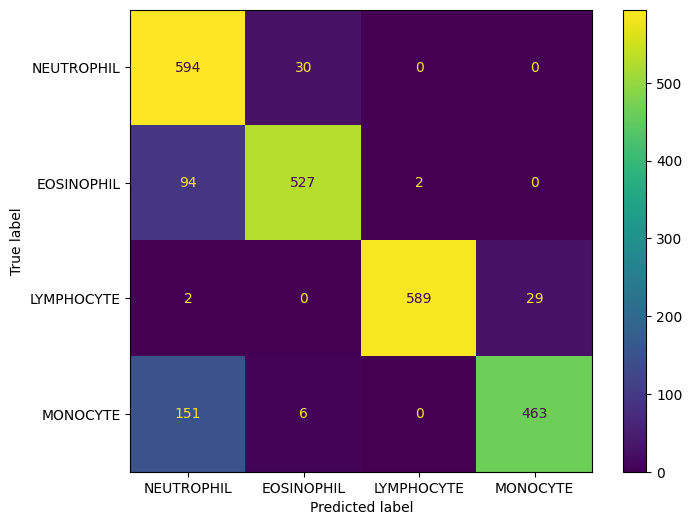

In [14]:
# Validate and Visualize
Model = torch.load('./saved_models/GoogleNet_'+tarData+'.pth', map_location=device)
val_acc, cm, prec, f1, recall, time_batch = validate(Model, TestLoader, numClass)
print('Validation Accuracy = ', val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm, classNames)

perfgoogleNet = {'Modelname':['GoogleNet_'+tarData], 'Val Acc.': val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}

### SqeezeNet

In [15]:
# Main Training loop for all target dataset with pretrained sourse model on CWRU DE fault, Dia=7Mil, load = 0hp

Model = SqeezeNet(numClass)
Model.to(device)
optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
print(f'Fine tuning SqeezeNet model for traget data: {tarData}')
Model = train(Model, TrainLoader, TestLoader, optC, criterion)
torch.save(Model,'./saved_models/SqeezeNet_'+tarData+'.pth')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth
100%|██████████| 4.78M/4.78M [00:00<00:00, 23.3MB/s]


Fine tuning SqeezeNet model for traget data: BloodCell
Starting Training Loop...
[0/20]   Train Accuracy = 65.29    Val Accuracy = 73.58
[1/20]   Train Accuracy = 91.01    Val Accuracy = 77.04
[2/20]   Train Accuracy = 95.43    Val Accuracy = 77.24
[3/20]   Train Accuracy = 97.69    Val Accuracy = 86.09
[4/20]   Train Accuracy = 98.49    Val Accuracy = 86.01
[5/20]   Train Accuracy = 98.77    Val Accuracy = 82.99
[6/20]   Train Accuracy = 99.57    Val Accuracy = 86.37
[7/20]   Train Accuracy = 99.15    Val Accuracy = 86.81
[8/20]   Train Accuracy = 98.79    Val Accuracy = 88.34
[9/20]   Train Accuracy = 99.32    Val Accuracy = 87.74
[10/20]   Train Accuracy = 99.85    Val Accuracy = 86.65
[11/20]   Train Accuracy = 99.92    Val Accuracy = 87.49
[12/20]   Train Accuracy = 99.80    Val Accuracy = 84.64
[13/20]   Train Accuracy = 99.60    Val Accuracy = 84.88
[14/20]   Train Accuracy = 99.82    Val Accuracy = 85.16
[15/20]   Train Accuracy = 99.80    Val Accuracy = 87.86
[16/20]   Train A

Validation Accuracy =  89.3848009650181
__________________________________________________
Pricision Score = 0.9121124099372679
__________________________________________________
F_1 Score =  0.8954512724982435
__________________________________________________
Recall Score =  0.893787672246806
__________________________________________________
Response time per batch 0.003456592559814453


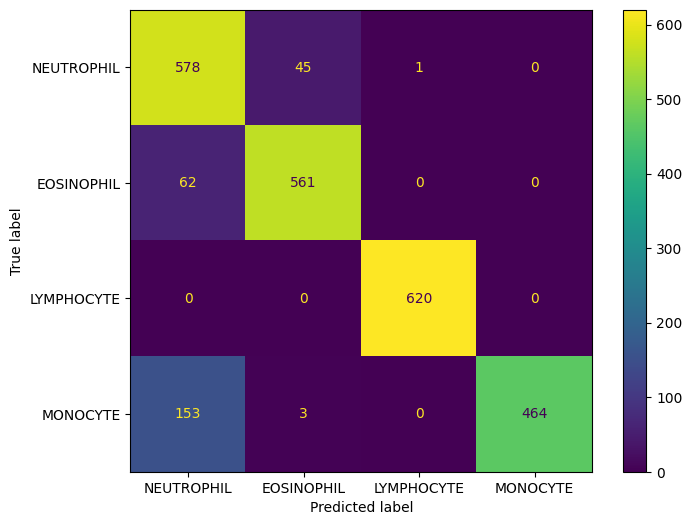

In [16]:
# Validate and Visualize
Model = torch.load('./saved_models/SqeezeNet_'+tarData+'.pth', map_location=device)
val_acc, cm, prec, f1, recall, time_batch = validate(Model, TestLoader, numClass)
print('Validation Accuracy = ', val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm, classNames)

perfSqeezeNet = {'Modelname':['SqeezeNet_'+tarData], 'Val Acc.': val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}